#### https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/

In [1]:
# import matlab.engine
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import datetime
from scipy.io import loadmat
from collections import defaultdict
from IPython.display import clear_output
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from IPython.display import clear_output

# eng = matlab.engine.start_matlab()

Using TensorFlow backend.


In [3]:
quietDays = np.array(eng.quiet())
# Quiet days from 2009/09/5 to 2009/09/19
# quietDays[1580-1] = 2009/09/14

year = np.int16(quietDays[1580-1][0])
month = np.int16(quietDays[1580-1][1])
day = np.int16(quietDays[1580-1][2])
hour = 0
minute = 0
second = 0
numberOfDaysWithData = 10


startDateMatlab = [year, month, day, hour, minute, second]
endDateMatlab = [year, month, day+numberOfDaysWithData, hour, minute, second]

startDate = datetime.datetime(year, month, day, hour, minute, second)
endDate = datetime.datetime(year, month, day+numberOfDaysWithData, hour, minute, second)


stationsWithNoData = []
stationsNonexistentInFolder = []
stationsOut = dict()
dotsX=[]
dotsY=[]
dotsHeights=[]
stationIndicatorVariation = defaultdict(list)

mat = loadmat("../../../../opt/dir.indices/station.mat")

allMatData = mat.get("station", "none")[0]
allStationCodes=[]

for x in allMatData:
    allStationCodes.append(x[1][0])
    

In [7]:
%%time
st='clf'
try:
    stationsOut[st] = eng.indices_alpha(matlab.double(startDateMatlab), matlab.double(endDateMatlab),str(st))
except:
    stationsNonexistentInFolder.append(st)

CPU times: user 20.2 ms, sys: 14.2 ms, total: 34.4 ms
Wall time: 683 ms


In [8]:
def IndicatorCalculation(dataSt, timeshift, currentDate):
    
#     a1=np.float32(dataSt.get("a1")[timeshift])
    x=np.float32(dataSt.get("x")[timeshift])
    x1=np.float32(dataSt.get("x1")[timeshift])
    x2=np.float32(dataSt.get("x2")[timeshift])
#     x3=np.float32(dataSt.get("x3")[timeshift])
#     x4=np.float32(dataSt.get("x4")[timeshift])
    y=np.float32(dataSt.get("y")[timeshift])
    y1=np.float32(dataSt.get("y1")[timeshift])
#     y2=np.float32(dataSt.get("y2")[timeshift])
#     y3=np.float32(dataSt.get("y3")[timeshift])
#     y4=np.float32(dataSt.get("y4")[timeshift])
    z1=np.float32(dataSt.get("z1")[timeshift])
    stLongeo=np.float32(dataSt.get("longeo"))
    stLatgeo=np.float32(dataSt.get("latgeo"))
    stAlt=np.float32(dataSt.get("alt"))
    
    currentDateMatlab = [currentDate.year, currentDate.month, currentDate.day, currentDate.hour, currentDate.minute, currentDate.second]
    
    b=eng.igrf(matlab.double([stLongeo]), matlab.double([stLatgeo]), matlab.double([stAlt]), matlab.double([currentDateMatlab]), nargout=4)
    
    ratio = (((math.sqrt(pow(x1, 2)+pow(y1, 2)+pow(z1, 2)))/b[3])-1)*100
#     indicator = gaussian(ratio, 1, 0)
    return np.round(x,10)

In [9]:
%%time
stationIndicatorVariation.clear()
numberOfMinutesNeededInTheTimeStamp = 2880
timeBetweenValues = 8
dataResolution = 0
dataBeforeNormalizaton = np.array([])

if 360%(numberOfMinutesNeededInTheTimeStamp/timeBetweenValues)==0:
    dataResolution = 360/(numberOfMinutesNeededInTheTimeStamp/timeBetweenValues)
    
    delta = endDate-startDate
    totalMinutes = (delta.total_seconds()+1)/60
    for i in range(0, np.int16(totalMinutes), timeBetweenValues):
        try:
            update = datetime.timedelta(minutes=i)
            currentDate = startDate+update
            stationIndicatorVariation['clf'].append(float(IndicatorCalculation(stationsOut.get('clf'), i, currentDate)))
        except:
            None
            
else:
    print("!ERROR! -- Your timeBetweenValues must be a multiple of the chosen time delta's amount of minutes -- !ERROR!")
    sys.exit

dataset = np.asarray(stationIndicatorVariation['clf']).reshape(-1,1)
# scaler = MinMaxScaler(feature_range=(0, 1))
# dataset = scaler.fit_transform(dataset)

CPU times: user 2 s, sys: 89.4 ms, total: 2.09 s
Wall time: 3.25 s


In [10]:
np.save('clf_data', dataset)

In [2]:
dataset_npy = np.load('clf_data.npy')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_npy = scaler.fit_transform(dataset_npy)

In [3]:
EMA = 0.5
gamma = 0.05
dataset_smoothed = dataset_npy.copy()
for ti in range(dataset_npy.shape[0]):
    EMA = gamma*dataset_smoothed[ti] + (1-gamma)*EMA
    dataset_smoothed[ti] = EMA

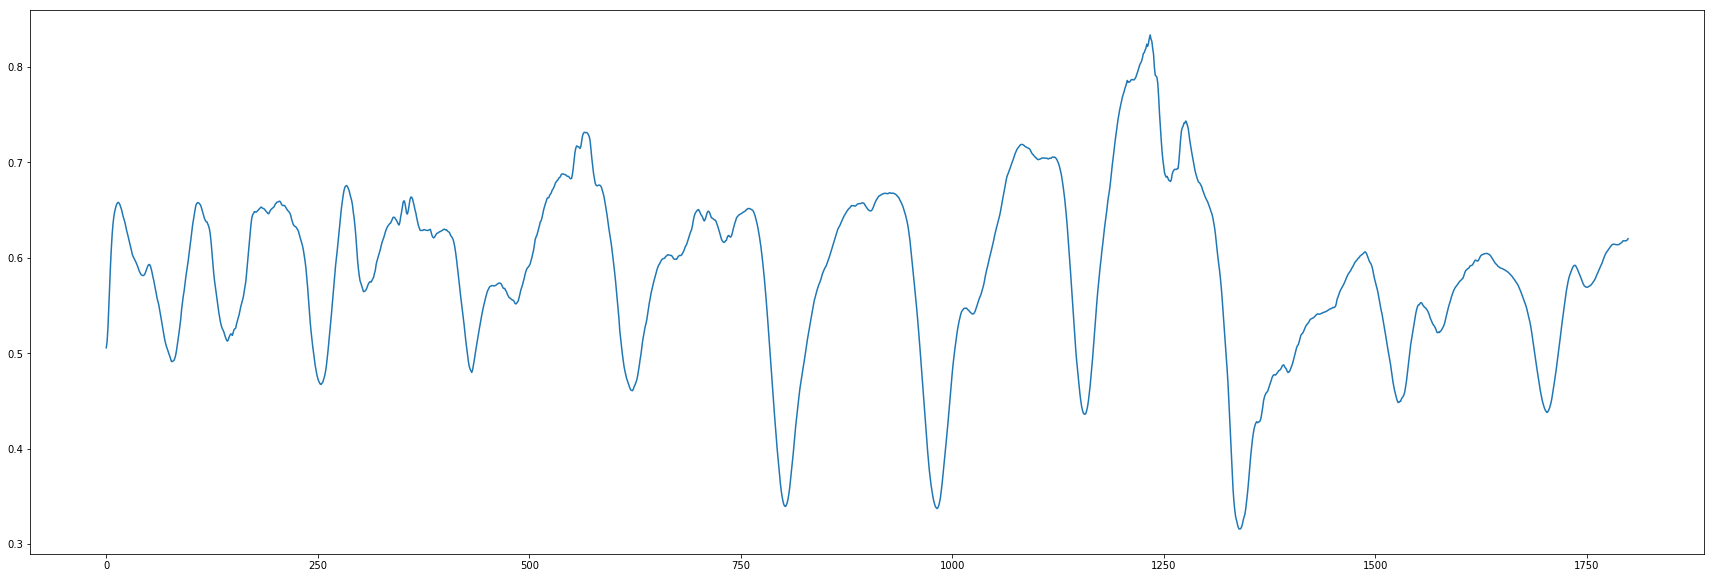

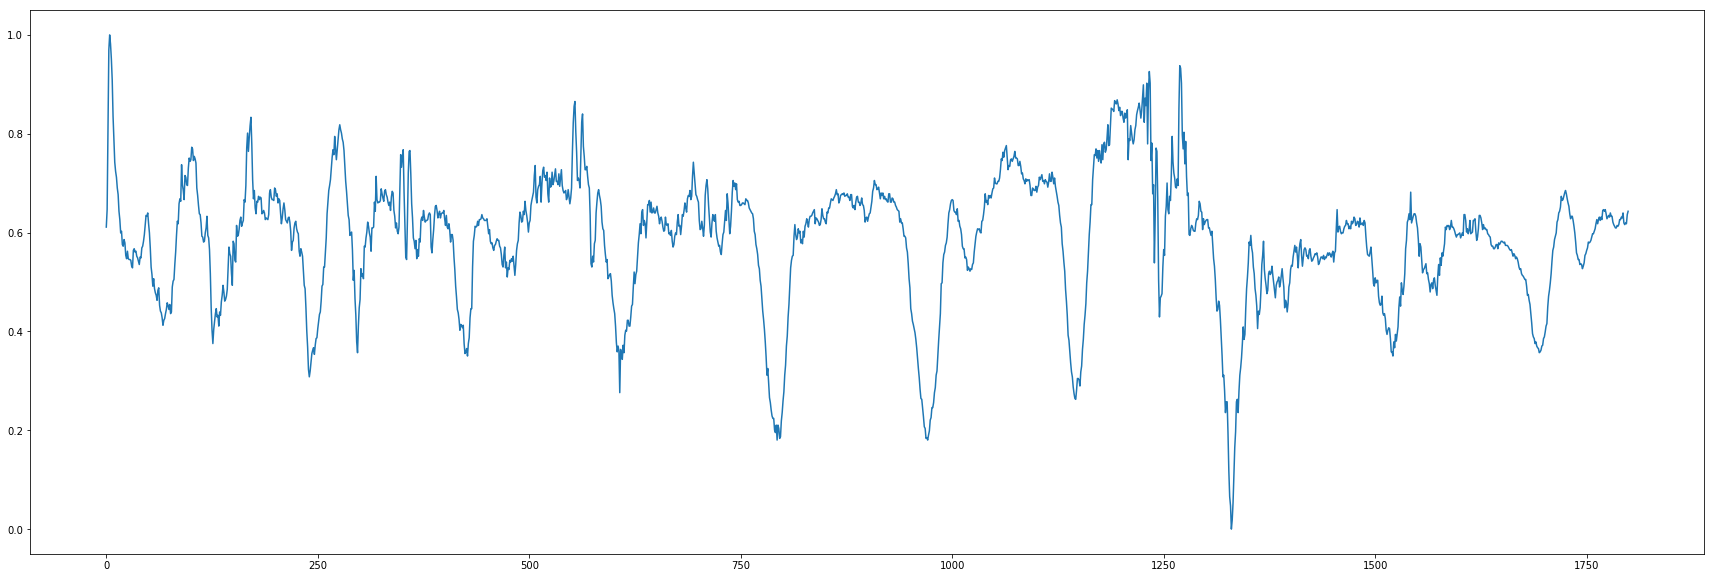

In [4]:
plt.figure(figsize=(30,10))
plt.plot(dataset_smoothed)
plt.show()
plt.figure(figsize=(30,10))
plt.plot(dataset_npy)
plt.show()

In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [6]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [7]:
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	# rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test

In [8]:
dataFrame = pd.DataFrame({'Y': dataset_npy[:, 0]})
# configure
n_lag = 1
n_seq = 3
n_test = 10

scaler, train, test = prepare_data(dataFrame, n_test, n_lag, n_seq)

/home/cristille/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [9]:
# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    model.fit(X, y, epochs=nb_epoch, batch_size=n_batch, verbose=1, shuffle=False)
    return model

In [38]:
model = fit_lstm(train, 1, 15, 1, 10, 1)

Epoch 1/10
1786/1786 [==============================] - 2s 903us/step - loss: 0.0247
Epoch 2/10
1786/1786 [==============================] - 2s 884us/step - loss: 0.0233
Epoch 3/10
1786/1786 [==============================] - 1s 823us/step - loss: 0.0231
Epoch 4/10
1786/1786 [==============================] - 1s 817us/step - loss: 0.0229
Epoch 5/10
1786/1786 [==============================] - 1s 814us/step - loss: 0.0228
Epoch 6/10
1786/1786 [==============================] - 1s 821us/step - loss: 0.0227
Epoch 7/10
1786/1786 [==============================] - 1s 817us/step - loss: 0.0226
Epoch 8/10
1786/1786 [==============================] - 1s 826us/step - loss: 0.0225
Epoch 9/10
1786/1786 [==============================] - 1s 829us/step - loss: 0.0225
Epoch 10/10
1786/1786 [==============================] - 1s 830us/step - loss: 0.0225


In [11]:
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]

In [12]:
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

In [39]:
forecasts = make_forecasts(model, 1, train, test, 1, 15)

In [16]:
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

In [21]:
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = np.array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

In [40]:
forecasts = inverse_transform(dataFrame, forecasts, scaler, n_test+2)

In [36]:
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    plt.figure(figsize=(30,15))
    plt.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    # show the plot

    plt.show()

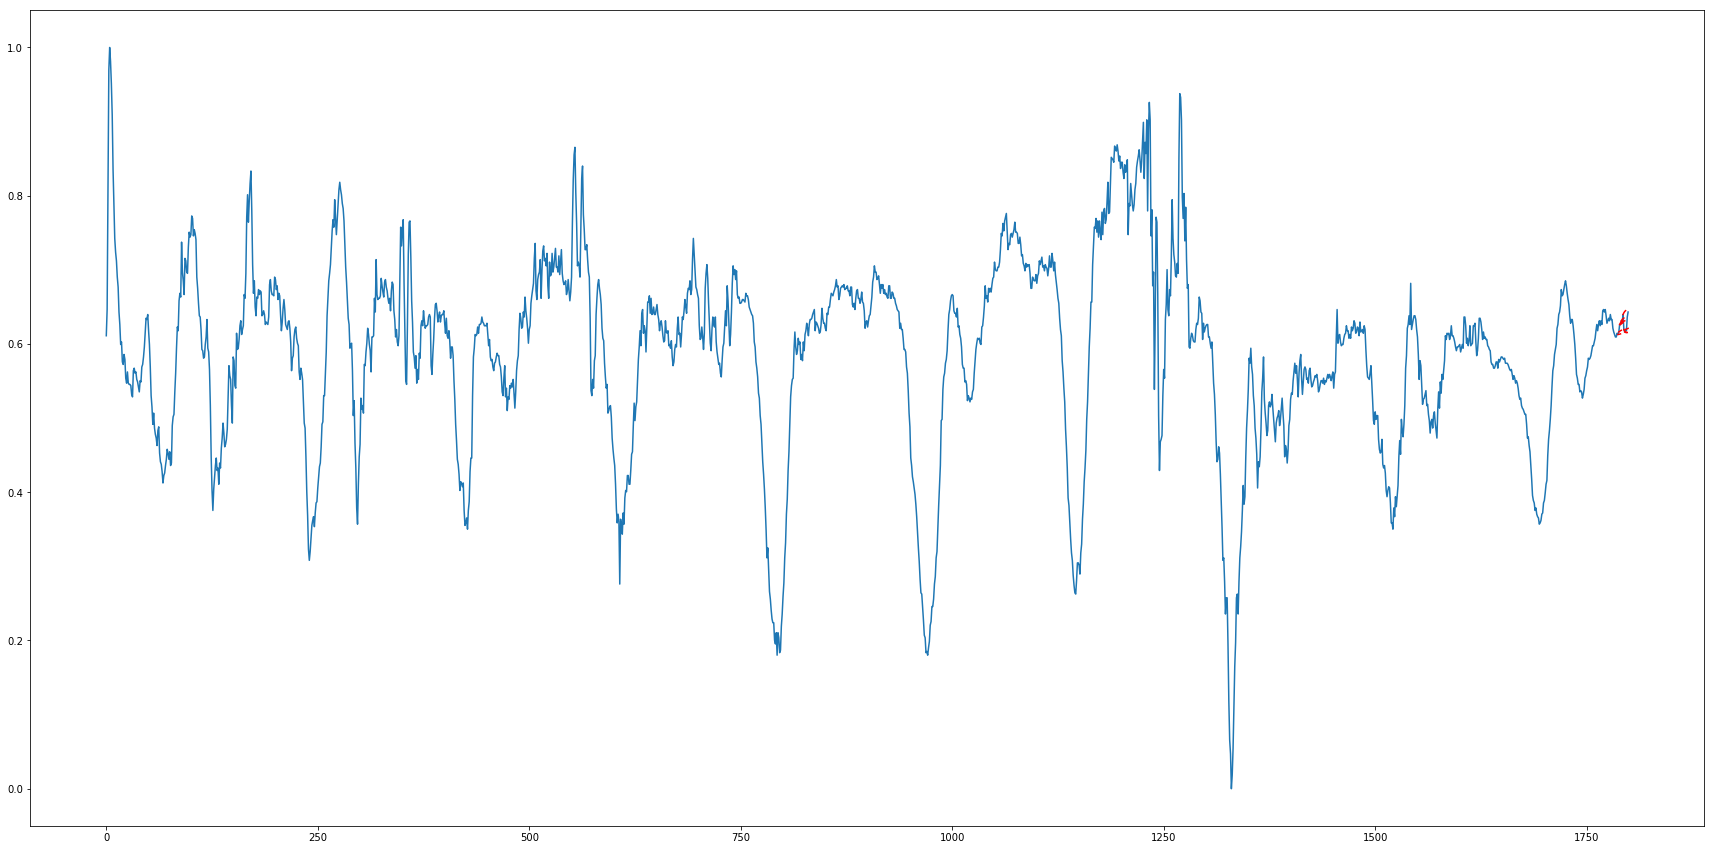

In [41]:
plot_forecasts(dataFrame, forecasts, n_test+2)

In [54]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [68]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [69]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

In [83]:
predictions = np.array([])
firstValue = testX[1].reshape(1,1,1)
pred=0
for i in range(testX.shape[0]):
    if i==0:
        pred=model.predict(firstValue)
    else: pred=model.predict(pred.reshape(1,1,1))
    predictions = np.append(predictions, pred)

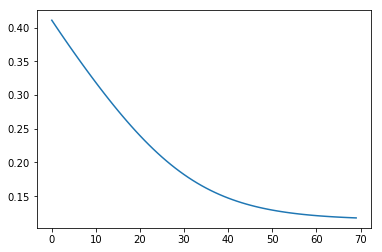

In [84]:
plt.plot(predictions)

In [82]:
model.predict(testX[1].reshape(1,1,1))

(1, 1)

In [44]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.63 RMSE
Test Score: 2.14 RMSE


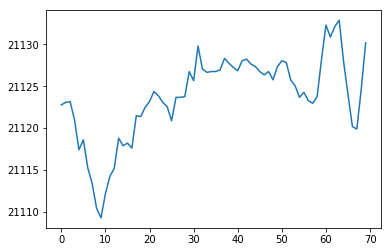

In [46]:
plt.plot(testPredict)

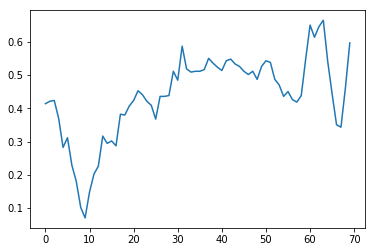

In [48]:
plt.plot(testX.reshape(testX.shape[0], 1))

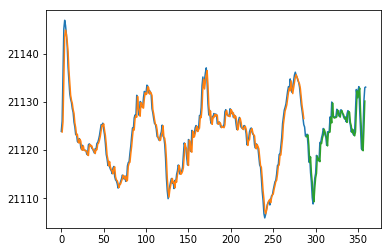

In [45]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [40]:
x = np.arange(0, indicatorVariationArray.shape[1], 1)
y = indicatorVariationArray[138]

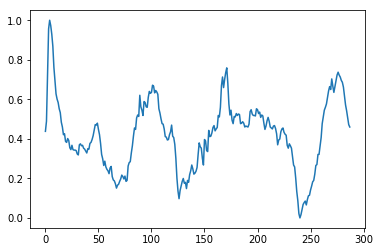

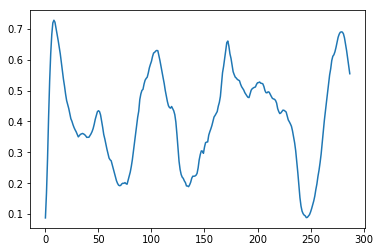

In [55]:
dataset = pd.DataFrame({'time': x, 'indicator': y})
indicator_data = dataset['indicator'].values

x_train = np.asarray(dataset['indicator'].values)


plt.plot(indicator_train)
plt.show()
plt.plot(indicator_train_smoothed)
plt.show()

In [54]:
EMA = 0.0
gamma = 0.2
indicator_train_smoothed = indicator_train.copy()
for ti in range(indicator_train.shape[0]):
    EMA = gamma*indicator_train_smoothed[ti] + (1-gamma)*EMA
    indicator_train_smoothed[ti] = EMA

# Used for visualization and test purposes
# all_mid_data = np.concatenate([train_data,test_data],axis=0)

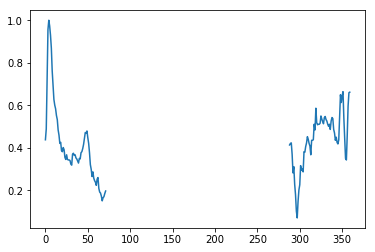

In [14]:
datasetWithGap = np.array([])
splitGap = int(0.20*len(indicator_data))
datasetWithGap = np.copy(indicator_data)
datasetWithGap[splitGap:len(indicator_data)-splitGap] = np.nan
datasetWithGapTest = indicator_data[splitGap:len(indicator_data)-splitGap]
plt.plot(datasetWithGap)
# plt.plot(datasetWithGapTest)

In [47]:
from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd

dataset = pd.DataFrame({'time': x, 'indicator': y})


indicator_data = dataset['indicator'].values
indicator_data = indicator_data.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(indicator_data))

indicator_train = indicator_data[:split]
indicator_test = indicator_data[split:]

look_back = 1

train_generator = TimeseriesGenerator(indicator_train, indicator_train, length=look_back, batch_size=1)     
test_generator = TimeseriesGenerator(indicator_test, indicator_test, length=look_back, batch_size=32)

In [31]:
TimeseriesGenerator

keras.preprocessing.sequence.TimeseriesGenerator

In [32]:
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(train_generator, epochs=50, verbose=1)

Epoch 1/50
287/287 [==============================] - 1s 4ms/step - loss: 0.1054
Epoch 2/50
287/287 [==============================] - 1s 3ms/step - loss: 0.0218
Epoch 3/50
287/287 [==============================] - 1s 3ms/step - loss: 0.0169
Epoch 4/50
287/287 [==============================] - 1s 3ms/step - loss: 0.0132
Epoch 5/50
287/287 [==============================] - 1s 3ms/step - loss: 0.0093
Epoch 6/50
287/287 [==============================] - 1s 3ms/step - loss: 0.0062
Epoch 7/50
287/287 [==============================] - 1s 3ms/step - loss: 0.0040
Epoch 8/50
287/287 [==============================] - 1s 3ms/step - loss: 0.0029
Epoch 9/50
287/287 [==============================] - 1s 3ms/step - loss: 0.0023
Epoch 10/50
287/287 [==============================] - 1s 3ms/step - loss: 0.0022
Epoch 11/50
287/287 [==============================] - 1s 3ms/step - loss: 0.0021
Epoch 12/50
287/287 [==============================] - 1s 3ms/step - loss: 0.0021
Epoch 13/50
287/287 [====

In [34]:
from sklearn.metrics import mean_squared_error

y_true = dataset['indicator'][split+look_back:]
y_pred = model.predict(test_generator)
mean_squared_error(y_true, y_pred)
# model.evaluate_generator(test_generator, 3000)

0.0026954231446878214

In [ ]:
test_predictions = []#Select last n_input values from the train data
first_eval_batch = scaled_train[-n_input:]#reshape the data into LSTM required (#batch,#timesteps,#features)
current_batch = first_eval_batch.reshape((1, n_input, n_features))
for i in range(len(test)):# get prediction, grab the exact number using the [0]
    pred = model.predict(current_batch)[0]# Add this prediction to the list
    test_predictions.append(pred)# The most critical part, update the (#batch,#timesteps,#features
# using np.append(
# current_batch[:        ,1:   ,:] ---------> read this as
# current_batch[no_change,1:end,no_change]
# (Do note the second part has the timesteps)
# [[pred]] need the double brackets as current_batch is a 3D array
# axis=1, remember we need to add to the second part i.e. 1st axis  current_batch = np.append(current_batch[:,1:,:],
                          [[current_pred]],
                          axis=1)

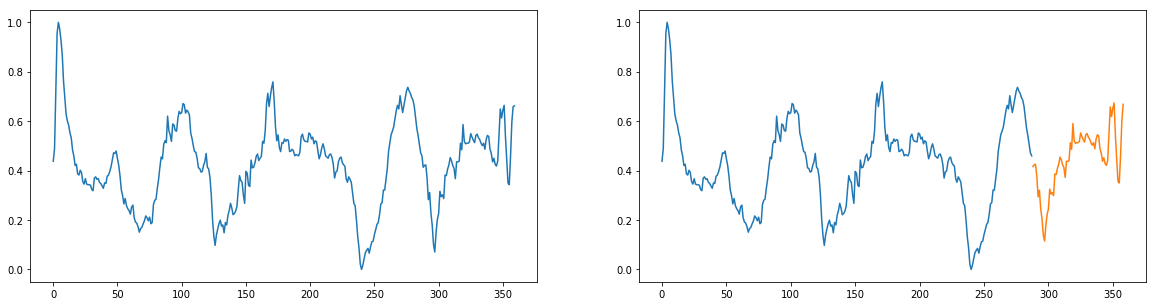

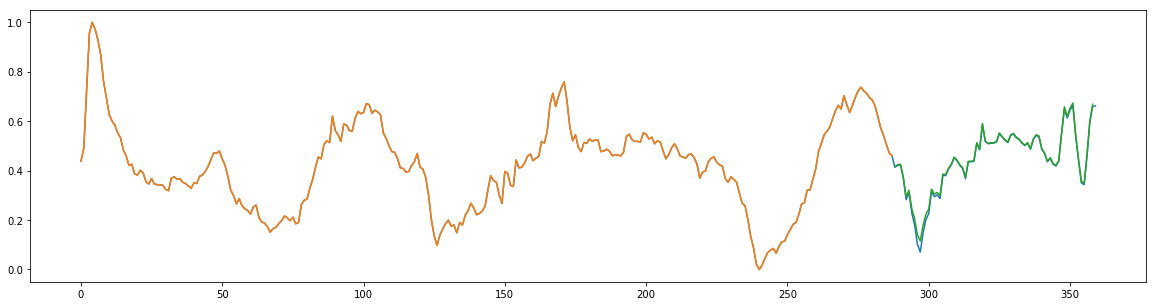

In [35]:
xPlot = np.arange(split+look_back-1,360-1,1)
fig,(ax1, ax2) = plt.subplots(1,2)
fig2,(ax3)=plt.subplots(1,1)
ax1.plot(dataset['indicator'])
ax2.plot(indicator_train)
ax2.plot(xPlot,y_pred)
ax3.plot(dataset['indicator'])
ax3.plot(indicator_train)
ax3.plot(xPlot,y_pred)
fig.set_size_inches(20,5)
fig.show()
fig2.set_size_inches(20,5)
fig2.show()

In [ ]:
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

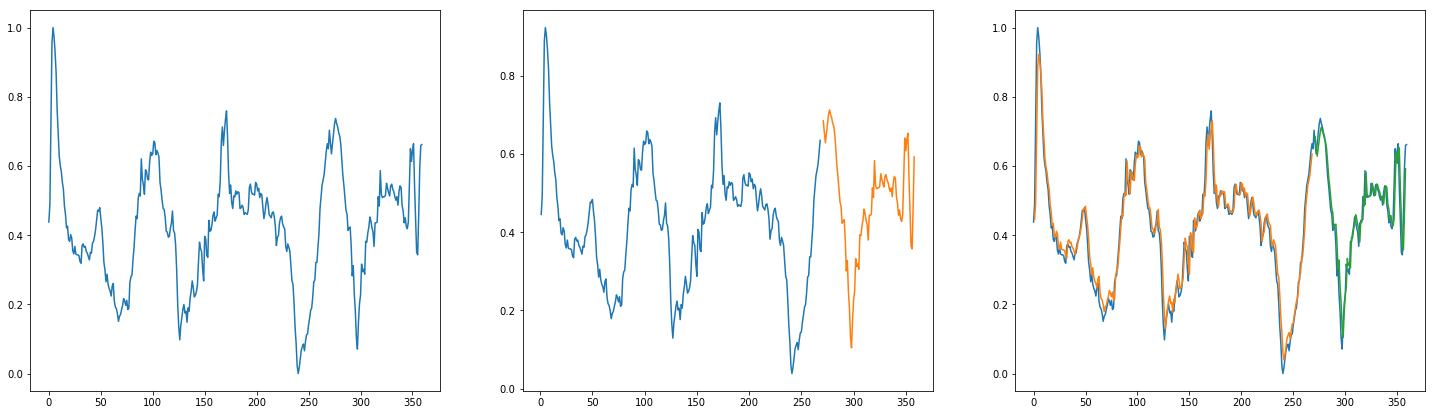

In [300]:
fig,(ax1, ax2, ax3) = plt.subplots(1,3)

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
 
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
 
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
 
ax1.plot(dataset)
ax2.plot(trainPredictPlot)
ax2.plot(testPredictPlot)
ax3.plot(dataset)
ax3.plot(trainPredictPlot)
ax3.plot(testPredictPlot)
fig.set_size_inches(25,7)
fig.show()

In [48]:
X=np.array([])
Y=np.array([])
Z=np.array([])

for t in range(0, indicatorVariationArrayLocalTime.shape[1]):
    Y = np.append(Y, t)
    for l in range(0, indicatorVariationArrayLocalTime.shape[0]):
        X = np.append(X, l)
        if not math.isnan(indicatorVariationArrayLocalTime[l][t]):
            Z = np.append(Z, indicatorVariationArrayLocalTime[l][t])

X=X.reshape(X.shape[0], 1)
Y=Y.reshape(Y.shape[0], 1)
Z=Z.reshape(Z.shape[0], 1)

In [49]:
value = 50
print(X.shape,Y.shape,Z.shape)

((32400, 1), (180, 1), (12420, 1))


ValueError: shape mismatch: objects cannot be broadcast to a single shape

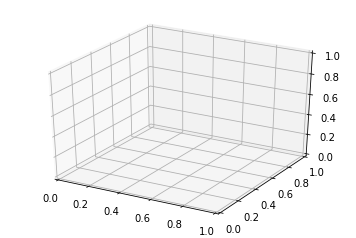

In [50]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
dem3d=ax.plot_surface(X,Y,Z,cmap='afmhot', linewidth=0)
plt.show()
